In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
import time
from IPython.display import Image
from neuralnets.layers import *
from neuralnets.helper import *
import os

In [2]:
content_file_name = 'content.jpg'
style_file_name = 'style.jpg'

In [3]:
vggmat = scipy.io.loadmat('./nn_model/imagenet-vgg-verydeep-19.mat')
image_content = imread('./images/'+content_file_name)
image_style = imread('./images/'+style_file_name)
# resize style image
image_style = scipy.misc.imresize(image_style, image_content.shape).astype('float32')

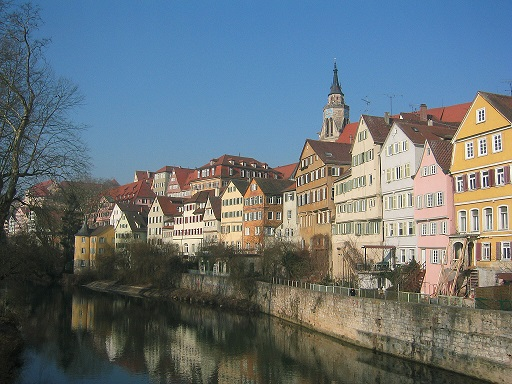

In [4]:
# content image
Image(filename = './images/'+content_file_name)

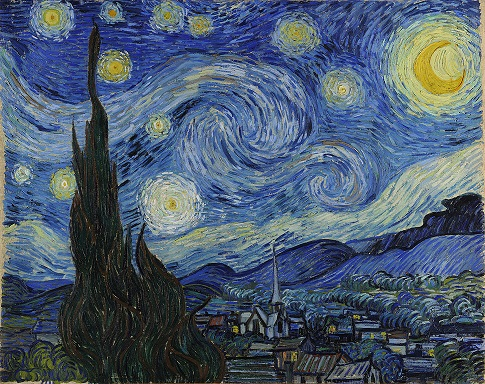

In [5]:
# style image
Image(filename = './images/'+style_file_name)

In [6]:
mean_pixel = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [7]:
# Select different layers for different effects
#CONTENT_LAYERS = ['relu4_2']
CONTENT_LAYERS = ['conv4_2']
content_features = {}
with tf.Session() as sess:
    content_pre = imgpreprocess(image_content, mean_pixel)
    content_net = vgg_net(content_pre, vggmat)
    for layer in CONTENT_LAYERS:
        content_features[layer] = content_net[layer].eval()

In [8]:
# Select different layers for different effects
#STYLE_LAYERS = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1','relu5_1']
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1','conv5_1']
style_features = {}
with tf.Session() as sess:
    style_pre = imgpreprocess(image_style, mean_pixel)
    style_net = vgg_net(style_pre, vggmat)
    for layer in STYLE_LAYERS:
        style_features[layer] = np_gram_matrix(style_net[layer].eval())

In [9]:
# Target image initialization
#initial = tf.random_normal(image_content.shape)
#initial = tf.Variable(initial)
initial = tf.Variable(content_pre)
image_net = vgg_net(initial, vggmat)

In [10]:
ratio = 1e-3
content_weight = 1
style_weight = 1/ratio
layer_weights = [0.2,0.2,0.2,0.2,0.2]
iterations = 20
niter = 50

In [11]:
# content loss
content_loss = 0
for content_layer in CONTENT_LAYERS:
    size = content_features[content_layer].size
    content_loss += (tf.nn.l2_loss(image_net[content_layer] - content_features[content_layer]) / size)

In [12]:
# style loss
style_loss = 0
for style_layer, weight in zip(STYLE_LAYERS, layer_weights):
    layer = image_net[style_layer]
    _, h, w, n = layer.get_shape()
    size = h.value * w.value * n.value
    gram = tf_gram_matrix(layer)
    style_gram = style_features[style_layer]
    style_loss += weight*(tf.nn.l2_loss(gram - style_gram) / style_gram.size)

In [13]:
# overall loss
loss = content_weight*content_loss + style_weight*style_loss

In [14]:
# Start running, also store losses.
closses, slosses, tlosses = [], [], []
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B',  options={'maxiter': niter})
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(vgg_net(initial, vggmat))
    for i in range(iterations):
        optimizer.minimize(sess)
        try:
            os.makedirs('./checks/'+str.split(content_file_name,'.')[0])
        except OSError:
            pass
        img = initial.eval()
        timestr = time.strftime("%Y%m%d_%H%M%S")
        filename_img = './checks/'+str.split(content_file_name,'.')[0]+'/'+timestr+'.jpg'
        tp = imgunprocess(img, mean_pixel).reshape(image_content.shape)
        imsave(filename_img, tp)
        print('Iteration %d/%d' % (i + 1, iterations))
        print('  content loss: %g' % content_loss.eval())
        print('    style loss: %g' % style_loss.eval())
        print('    total loss: %g' % loss.eval())
        closses.append(content_loss.eval())
        slosses.append(style_loss.eval())
        tlosses.append(loss.eval())
    output = imgunprocess(img, mean_pixel).reshape(image_content.shape)
    # save model
    writer = tf.summary.FileWriter("./log/{}".format('final'), sess.graph)
    saver = tf.train.Saver()
    saver.save(sess, './saved_model/{}'.format('final'))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 117052.171875
  Number of iterations: 51
  Number of functions evaluations: 59
Iteration 1/20
  content loss: 97413.6
    style loss: 19.6386
    total loss: 117052
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 95933.820312
  Number of iterations: 51
  Number of functions evaluations: 60
Iteration 2/20
  content loss: 85416.9
    style loss: 10.5169
    total loss: 95933.8
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 89458.500000
  Number of iterations: 51
  Number of functions evaluations: 56
Iteration 3/20
  content loss: 80313.2
    style loss: 9.14536
    total loss: 89458.5
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Obj

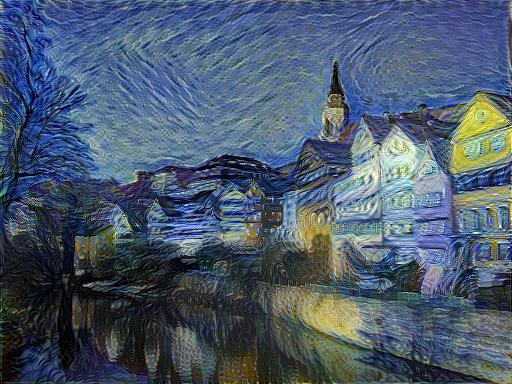

In [15]:
# save final output
imsave('./images/output_'+content_file_name+"_"+style_file_name, output)
Image(filename = './images/output_'+content_file_name+"_"+style_file_name)

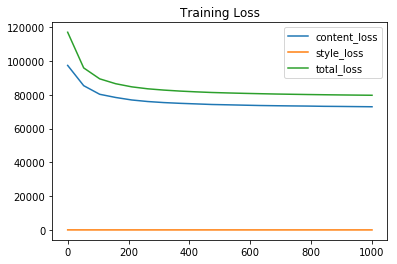

In [16]:
#Plot losses
plt.plot(np.linspace(0,1000,20),closses, label="content_loss")
plt.plot(np.linspace(0,1000,20),slosses, label="style_loss")
plt.plot(np.linspace(0,1000,20), tlosses, label="total_loss")
plt.title("Training Loss")
plt.legend()
plt.show()